In [ ]:
!pip install keras-tuner
!pip install scikeras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.5 MB/s eta 0:00:00

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from google.colab import drive
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalMaxPooling2D, Dropout, Dense, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay


- Carichiamo la parte convoluzionale del modello vgg16 pre-addestrato su ImageNet

In [ ]:
conv_base = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False,classes=3,classifier_activation="softmax")
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

- Congeliamo tutti i livelli della base convoluzionale di ResNet50 tranne gli ultimi 4 livelli

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

- Carichiamo da kaggle la cartella contenente le immagini di dataset

In [ ]:
import os
import zipfile

# 1. Verifica che il file kaggle.json sia presente
kaggle_json = "kaggle.json"

if not os.path.exists(kaggle_json):
    raise FileNotFoundError("Il file 'kaggle.json' non è stato trovato nella cartella corrente. ")

# 2. Copia kaggle.json nella cartella .kaggle dell’utente
print(" Configurazione dell'API Kaggle...")
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

with open(kaggle_json, "rb") as src:
    with open(os.path.join(kaggle_dir, "kaggle.json"), "wb") as dst:
        dst.write(src.read())

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# 3. Installa la libreria kaggle (se non è installata)
try:
    import kaggle
except ImportError:
    print(" Installazione della libreria kaggle...")
    !pip install -q kaggle

# 4. Scarica il dataset
print("\n Download del dataset da Kaggle...")
!kaggle datasets download -d fatemehmehrparvar/lung-disease -p ./dataset --force

# 5. Estrai lo ZIP
zip_path = "./dataset/lung-disease.zip"
extract_path = "./lung_decompressed"

print(" Estrazione del file zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 6. Verifica i file
print("\n Download e decompressione completati.")
print(" File estratti:")
print(os.listdir(extract_path))

- Definizione dei percorsi delle immagini

In [ ]:
import os

base_dir = os.path.join(".", "lung_decompressed", "Lung X-Ray Image", "Lung X-Ray Image")

lung_opacity = os.path.join(base_dir, "Lung_Opacity")
normal = os.path.join(base_dir, "Normal")
viral_pne = os.path.join(base_dir, "Viral Pneumonia")

- Carichiamo le immagini negli array delle features e delle labels

In [ ]:
features = []
labels = []

for img in tqdm(os.listdir(lung_opacity)):
    img_path = os.path.join(lung_opacity, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

for img in tqdm(os.listdir(normal)):
    img_path = os.path.join(normal, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

for img in tqdm(os.listdir(viral_pne)):
    img_path = os.path.join(viral_pne, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

100%|██████████| 1100/1100 [00:01<00:00, 653.66it/s]


- Aggiungiamo le etichette per ogni classe

In [ ]:
for img in os.listdir(lung_opacity):
    labels.append(0)
for img in os.listdir(normal):
    labels.append(1)
for img in os.listdir(viral_pne):
    labels.append(2)

- Mostriamo delle immagini casuali con le relative etichette

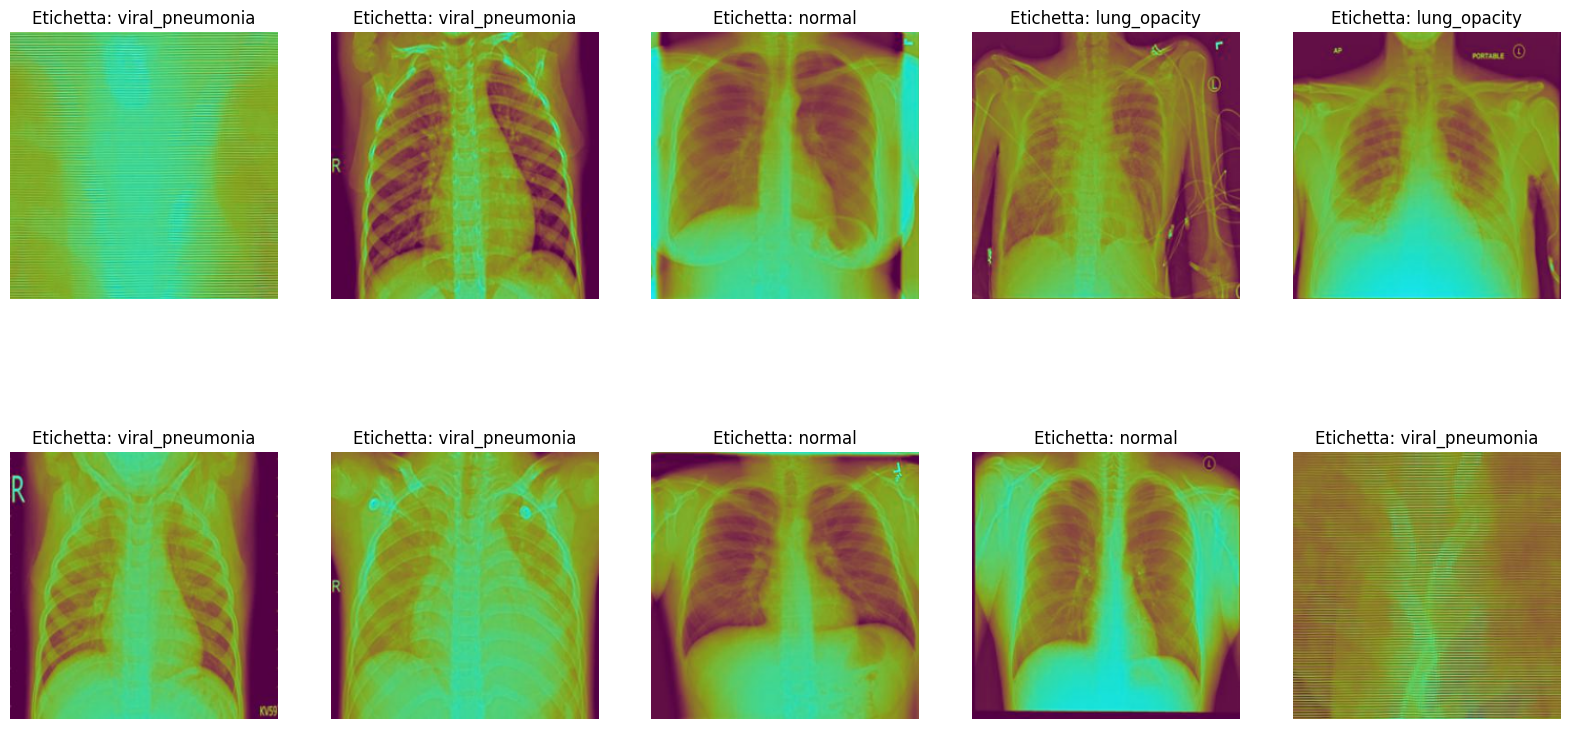

In [ ]:
label_names = {0: 'lung_opacity', 1: 'normal', 2: 'viral_pneumonia'}

indices = np.arange(len(features))
np.random.shuffle(indices)
features = np.array(features)[indices]
labels = np.array(labels)[indices]

num_images_to_display = min(10, len(features))

plt.figure(figsize=(20, 10))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(features[i].astype('uint8'))
    plt.title(f'Etichetta: {label_names[labels[i]]}')
    plt.axis('off')
plt.show()

- Conversione delle features e delle labels in array numpy

In [ ]:
X = np.array(features)
y = np.array(labels)

- Prima dividiamo in training e test set (80% training, 20% test)
- Poi dividiamo il training set rimanente in training e validation set (80% training, 20% validation)

In [ ]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)


- Conversione delle etichette in formato categorico

In [ ]:
y_trainE = to_categorical(y_train, num_classes=3)
y_valE = to_categorical(y_val, num_classes=3)
y_testE = to_categorical(y_test, num_classes=3)

# Modello
- Definizione di build_model per il tuning degli iperparametri

In [ ]:
def build_model(hp):
    datagen = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2)]
    )

    inputs = Input(shape=(255, 255, 3))
    x = datagen(inputs)
    x = tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x))(x)


    x = conv_base(x)

    x = GlobalMaxPooling2D()(x)

    x = Dense(hp.Int('units_1', 64, 256, step=64), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_rate_1', 0.3, 0.7))(x)

    x = Dense(hp.Int('units_2', 64, 256, step=64), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_rate_2', 0.3, 0.7))(x)

    x = Dense(hp.Int('units_3', 64, 256, step=64), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_rate_3', 0.3, 0.7))(x)

    x = Dense(hp.Int('units_4', 64, 256, step=64), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_rate_4', 0.3, 0.7))(x)

    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)


    model = Model(inputs, outputs)

    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',tf.metrics.F1Score()]) #++NN

    return model

- Effettuiamo la configurazione e la ricerca degli iperparametri

In [ ]:
tuner_dir = 'hyperparam_tuning/lung_disease_classification'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

tuner = kt.RandomSearch(
    build_model,
    objective= 'val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lung_disease_classification'
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

tuner.search(X_train, y_trainE, epochs=10, validation_data=(X_val, y_valE), callbacks=[early_stopping])

Trial 5 Complete [00h 01m 34s]
val_loss: 0.27573734521865845

Best val_loss So Far: 0.227009579539299
Total elapsed time: 00h 12m 10s


- Riassunto dei migliori iperparametri trovati

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Il miglior tasso di dropout del primo strato dropout è: {best_hps.get('dropout_rate_1')}
Il miglior tasso di dropout del secondo strato dropout è: {best_hps.get('dropout_rate_2')}
Il miglior tasso di dropout del secondo strato dropout è: {best_hps.get('dropout_rate_3')}
Il miglior tasso di dropout del secondo strato dropout è: {best_hps.get('dropout_rate_4')}
Il miglior learning rate è: {best_hps.get('learning_rate')}
""")



Il miglior tasso di dropout del primo strato dropout è: 0.3890004718114993
Il miglior tasso di dropout del secondo strato dropout è: 0.461266347475568
Il miglior tasso di dropout del secondo strato dropout è: 0.6582581633935091
Il miglior tasso di dropout del secondo strato dropout è: 0.6637874131822463
Il miglior learning rate è: 0.0012560732013762392



- Addestramento finale del modello con i migliori iperparametri

In [ ]:
model = tuner.hypermodel.build(best_hps)
history_fine_tuning = model.fit(X_train, y_trainE, epochs=10, validation_data=(X_val, y_valE), callbacks=[early_stopping])

Epoch 1/10
70/70 [==============================] - 24s 267ms/step - loss: 0.8536 - accuracy: 0.7014 - f1_score: 0.7005 - val_loss: 0.9150 - val_accuracy: 0.8291 - val_f1_score: 0.8336
Epoch 2/10
70/70 [==============================] - 19s 265ms/step - loss: 0.3988 - accuracy: 0.8728 - f1_score: 0.8726 - val_loss: 0.4304 - val_accuracy: 0.9065 - val_f1_score: 0.9080
Epoch 3/10
70/70 [==============================] - 16s 227ms/step - loss: 0.3408 - accuracy: 0.9015 - f1_score: 0.9016 - val_loss: 0.3155 - val_accuracy: 0.9173 - val_f1_score: 0.9183
Epoch 4/10
70/70 [==============================] - 18s 258ms/step - loss: 0.3165 - accuracy: 0.8988 - f1_score: 0.8990 - val_loss: 0.2795 - val_accuracy: 0.9227 - val_f1_score: 0.9228
Epoch 5/10
70/70 [==============================] - 16s 222ms/step - loss: 0.3038 - accuracy: 0.8984 - f1_score: 0.8990 - val_loss: 0.2335 - val_accuracy: 0.9209 - val_f1_score: 0.9206
Epoch 6/10
70/70 [==============================] - 18s 258ms/step - loss: 

- Valutazione e stampa dei risultati del modello

In [ ]:
loss, accuracy, f1  = model.evaluate(X_test, y_testE)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")
print(f"f1: {np.mean(f1):.3f}")

22/22 [==============================] - 9s 433ms/step - loss: 0.2623 - accuracy: 0.9137 - f1_score: 0.9177
Test loss: 0.262
Test accuracy: 0.914
f1: 0.918


- Scatterplot

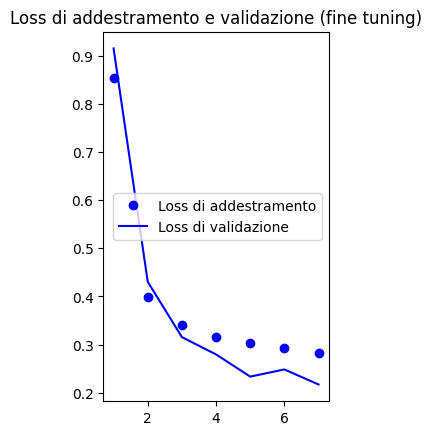

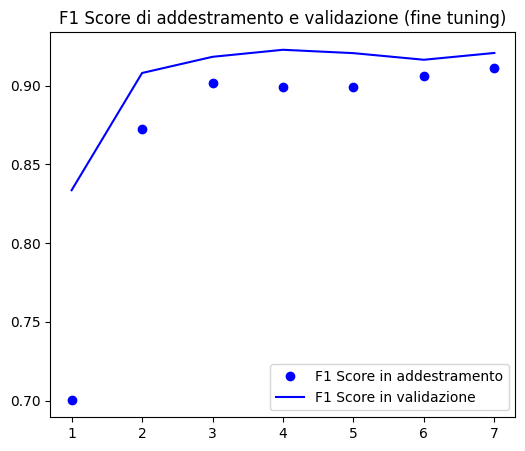

In [ ]:
acc = history_fine_tuning.history['accuracy']
val_acc = history_fine_tuning.history['val_accuracy']
loss = history_fine_tuning.history['loss']
val_loss = history_fine_tuning.history['val_loss']

f1_score = []
val_f1_score = []

epochs = range(1, len(acc) + 1)

for i in range(len(acc)):
  f1_score.append(np.mean(history_fine_tuning.history['f1_score'][i]))
  val_f1_score.append(np.mean(history_fine_tuning.history['val_f1_score'][i]))

# Plot della perdita (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Loss di addestramento")
plt.plot(epochs, val_loss, "b", label="Loss di validazione")
plt.title("Loss di addestramento e validazione (fine tuning)")
plt.legend()

plt.show()

# Plot dell'F1 score
plt.figure(figsize=(6, 5))
plt.plot(epochs, f1_score, "bo", label="F1 Score in addestramento")
plt.plot(epochs, val_f1_score, "b", label="F1 Score in validazione")
plt.title("F1 Score di addestramento e validazione (fine tuning)")
plt.legend()

plt.show()


Matrice di confusione

22/22 [==============================] - 4s 159ms/step


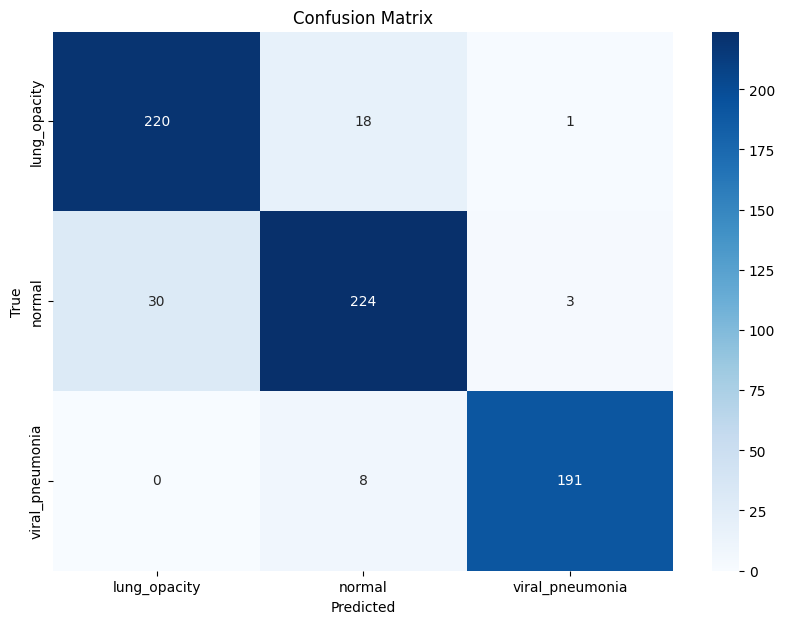

In [ ]:
y_predE = model.predict(X_test)
y_pred = np.argmax(y_predE, axis=1)
y_true = np.argmax(y_testE, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm_labels = ['lung_opacity', 'normal', 'viral_pneumonia']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()